In [1]:
import pandas as pd
import seaborn as sns
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
from pathlib import Path
plt.rcParams['pdf.fonttype']=42

## Gene distribution heterogeneity across Eukaryotes

Speckle depletion leads a collapse of gene expression from GC-rich genes which are clustered in GC-rich regions (isochores). Genes that are outside of these regions are not affected. How are genes generally distributed across Eukaryotes? Are they always clustered (dense) in GC-rich regions? To address this, we split Eukaryotic genomes into 10kb bins, and give them an "isochore" label depending on their GC-content. Then we calculate the number genes that fall into these isochore classes. If gene distribution is not related to GC-content of the genomic loci they find themselves in, the expectation would be that the larger the genomic coverage of an isochore is, the more genes it will contain, which would out null hypothesis. We use chi^2 test to see if deviations from this null hypothesis is significant for all genomes, use Cramér’s V statistic to calculate the effect size, and also visualize gene enrichments using scatterplots.

In [2]:
# Load the calculated data
gene_numbers_path = Path('data/pre-processed/all_eukaryotes_protein_coding_gene_counts.csv')
all_tables_chi_path = Path('data/pre-processed/all_genomes_isochores_gene_coverage_2025-02-23.pkl')


gene_numbers_df = pd.read_csv(gene_numbers_path)
all_tables_chi = pickle.load(open(all_tables_chi_path, 'rb'))
all_tables_chi['isochore'] = all_tables_chi.index
all_tables_chi

,isochore_coverage,gene_coverage,enrichment,organism_name,group,taxid,assembly_level,mean_GC_bins,stdev_GC_bins,chi2_stat,chi2_p_val,assembly,isochore
H1,0.435474,0.269627,-0.691622,Ornithorhynchus_anatinus,vertebrate_mammalian,9258,Chromosome,0.461419,0.056031,13336.300124,0.000000,GCF_004115215.2,H1
H2,0.207642,0.221310,0.091969,Ornithorhynchus_anatinus,vertebrate_mammalian,9258,Chromosome,0.461419,0.056031,13336.300124,0.000000,GCF_004115215.2,H2
H3,0.134301,0.416781,1.633818,Ornithorhynchus_anatinus,vertebrate_mammalian,9258,Chromosome,0.461419,0.056031,13336.300124,0.000000,GCF_004115215.2,H3
L1,0.005095,0.000992,-2.361235,Ornithorhynchus_anatinus,vertebrate_mammalian,9258,Chromosome,0.461419,0.056031,13336.300124,0.000000,GCF_004115215.2,L1
L2,0.217487,0.091290,-1.252404,Ornithorhynchus_anatinus,vertebrate_mammalian,9258,Chromosome,0.461419,0.056031,13336.300124,0.000000,GCF_004115215.2,L2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1,0.693427,0.688290,-0.010727,Ordospora_pajunii,fungi,3039483,Contig,0.428796,0.028528,0.430347,0.979918,GCF_021821965.1,H1
H2,0.013895,0.013744,-0.015755,Ordospora_pajunii,fungi,3039483,Contig,0.428796,0.028528,0.430347,0.979918,GCF_021821965.1,H2
H3,0.000025,NaN,NaN,Ordospora_pajunii,fungi,3039483,Contig,0.428796,0.028528,0.430347,0.979918,GCF_021821965.1,H3
L1,0.025601,0.024739,-0.049426,Ordospora_pajunii,fungi,3039483,Contig,0.428796,0.028528,0.430347,0.979918,GCF_021821965.1,L1


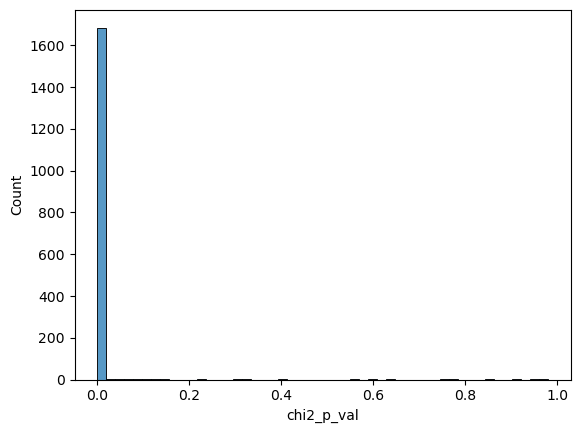

In [3]:
# Almost all of them are significant

df = (all_tables_chi
      .drop_duplicates(subset=['assembly'])
      .dropna(subset=['chi2_p_val'])
      .assign(chi2_p_val=lambda d: pd.to_numeric(d['chi2_p_val'], errors='coerce'))
      .dropna(subset=['chi2_p_val'])
)

ax = sns.histplot(data=df, x='chi2_p_val', bins=50, kde=False)
ax.set_xlabel('chi2_p_val');

In [4]:
# Load taxonomy information

phlyo_path = Path("data/pre-processed/phylo_info_2025-09-25.pickle")

phylo_info = pd.read_pickle(phlyo_path)

all_tables_chi_annotated = pd.merge(all_tables_chi,
         phylo_info.rename(columns={'group':'group_2'}),
         on='taxid',
         how='left'
        )

all_tables_chi_annotated = pd.merge(all_tables_chi_annotated,
         gene_numbers_df[['assembly', 'total_gene_number']],
         on='assembly',
         how='left'
        )

all_tables_chi_annotated = all_tables_chi_annotated.drop_duplicates(subset=['assembly', 'isochore'])

## Figure 6A

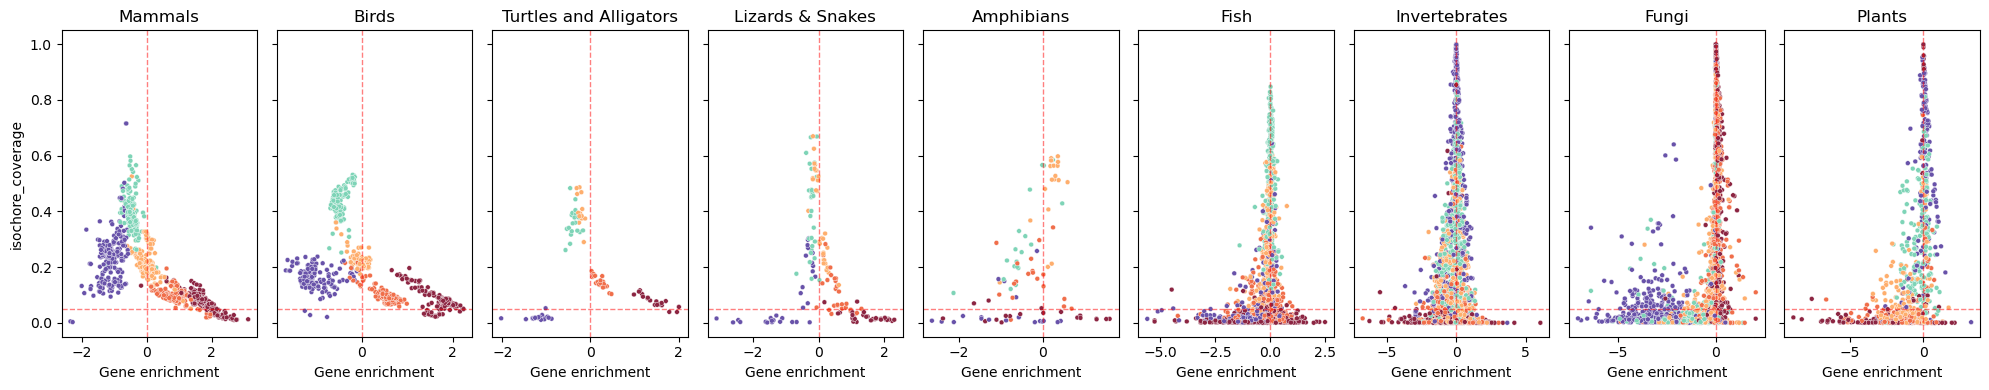

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20,4), 
                        sharex=False, 
                        sharey=True
                       )

order = ['H3', 'H2', 'H1', 'L2', 'L1']
palette = ['#8C2542', 
           '#F06E4A', 
           '#FEAE6D',
           '#7ED4B7',
           '#6852A9'
          ]
temp_df = all_tables_chi_annotated.copy()
temp_df['cats'] = temp_df.apply(lambda row: 'Turtles and Alligators' if row.cats in ['Turtles', 'Alligators & Crocs'] else row.cats, axis=1)

taxas = list(temp_df.dropna().cats.unique())

taxa_labels = ['Plants',
               'Fungi',
               'Invertebrates',
               'Fish',
               'Amphibians',
               'Lizards & Snakes',
               'Turtles and Alligators', 
               'Birds',
               'Mammals'
]

taxa_labels.reverse()

for index, ax in enumerate(axs.flatten()):
    taxa_label = taxa_labels[index]   
    data = temp_df[(temp_df.cats == taxa_label)]
    ax = sns.scatterplot(data=data,
                    x='enrichment',
                    y='isochore_coverage',
                    hue='isochore',
                    hue_order=order,
                    palette=palette,
                    s=12,
                    alpha=1,
                         legend=False,
                         rasterized=True,
                    ax=ax
                   )
    ax.axvline(x=0, linewidth=1, color='r', ls='--', alpha=0.5)
    ax.axhline(y=0.05, linewidth=1, color='r', ls='--', alpha=0.5)
    ax.set_xlabel('Gene enrichment')
    ax.set_title(f'{taxa_labels[index]}')

plt.tight_layout()

This plot shows very interesting patterns: In amniotes one finds more genes in GC-rich isochores H3 and H2 than expected, and at the same time one finds less genes than expected in GC-poor isochores L1 and L2. In other words, for example in mammals H3 isochore occupies ~5% of the genome, but these regions contains ~20% of protein coding genes, leading to an enrichment score of ~2.

In fish and invertebrates, we see a "christmas tree"-like pattern, this is likely because GC-content is not strongly correlated with distribution of genes, so when an isochore occupies ~70% of the genome, it also contains ~70% of genes etc. so the enrichment scores are close to 0. When isochores occupy very small parts of the genome (<5%), then we see more noise in enrichment scores, which is probably why the base of the distribution is wider.

Fungi have GC-rich genomes, but genes do not seem to be differentially distributed based on GC-content. One obvious exception appears to be the L1 regions that seems to be basically devoid of genes, leading to very negative enrichment scores. This is very likely the result of a well-known anti-transposon pathway called repeat-induced point mutations (RIP) see: https://www.frontiersin.org/journals/microbiology/articles/10.3389/fmicb.2020.622368/full

## SFigure 6A

/scratch/local/ipykernel_112775/3020743547.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


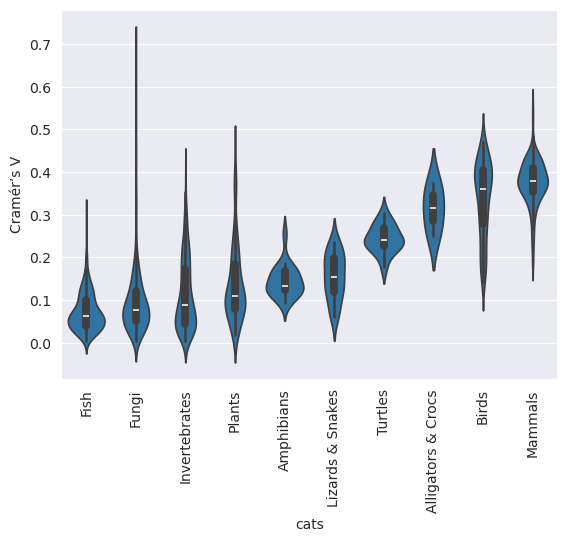

In [6]:
# chi^2 test are significant for most organisms, likely due to large number of genes are involved 
# and because small variations from expected distributions lead to statistically significant differences
# Cramér’s V is calculated from chi^2 statistic, and provides a kind of "effect size" by normalizing
# the chi^2 statistic with the number of genes and number of categories

with sns.axes_style("darkgrid"):
    tempd_df = all_tables_chi_annotated.drop_duplicates(subset=['taxid']).dropna().copy()
    tempd_df['Cramér’s V'] = np.sqrt(tempd_df.chi2_stat/(tempd_df.total_gene_number * 4))
    order = tempd_df.groupby('cats')['Cramér’s V'].median().sort_values(ascending=True).index   
    ax = sns.violinplot(tempd_df, x='cats', y='Cramér’s V', order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [7]:
import warnings
from pandas.errors import SettingWithCopyWarning 
warnings.filterwarnings('ignore', category=SettingWithCopyWarning) # Extremely annoying otherwise

assembly_id_list = list(all_tables_chi_annotated.assembly)
variation_driver = []
variation_direction = []
max_abs_key = lambda d: max(d, key=lambda k: abs(d[k]))
for assembly_id in assembly_id_list:
    df_temp = all_tables_chi_annotated[(all_tables_chi_annotated.assembly == assembly_id)]
    df_temp['expected'] = df_temp.isochore_coverage * df_temp.total_gene_number
    df_temp['observed'] = df_temp.gene_coverage * df_temp.total_gene_number
    df_temp['standardized_residuals'] = (df_temp.observed - df_temp.expected) / np.sqrt(df_temp.expected)
    d = dict(zip(df_temp.isochore, df_temp.standardized_residuals))
    variation_driver_key = max_abs_key(d)
    variation_driver.append(variation_driver_key)
    if df_temp[(df_temp.isochore == variation_driver_key)].enrichment.values > 0:
        variation_direction.append('Enriched')
    else:
        variation_direction.append('Depleted')

In [8]:
all_tables_chi_annotated_variation = all_tables_chi_annotated.copy()
all_tables_chi_annotated_variation = pd.merge(all_tables_chi_annotated_variation,
        pd.DataFrame({'assembly':assembly_id_list,
             'top_variation_driver':variation_driver,
                     'variation_direction':variation_direction}),
        on='assembly',
        how='left'
        ).drop_duplicates(subset=['assembly', 'isochore'])

## Figure 6B

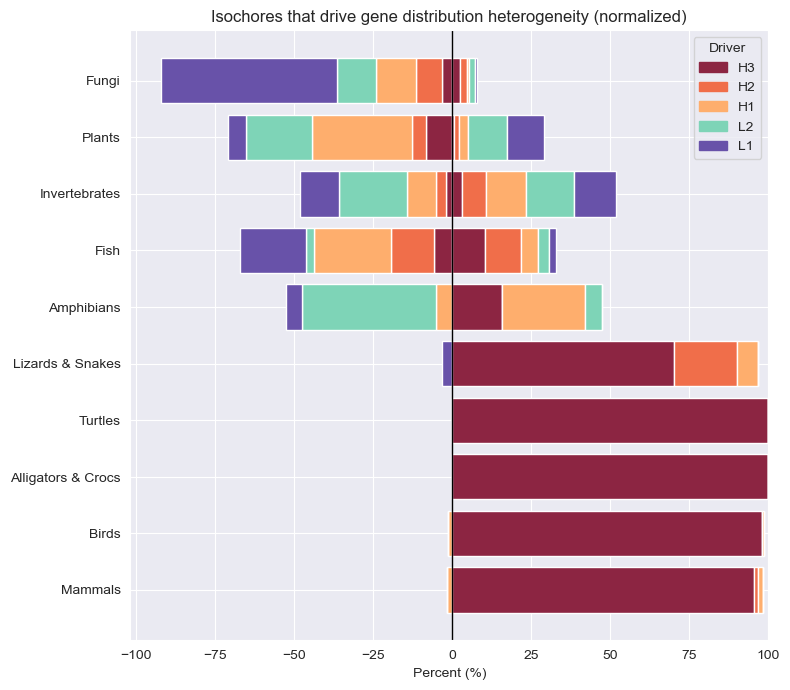

In [9]:
tempd_df = all_tables_chi_annotated_variation.drop_duplicates(subset=['assembly', 'isochore', 'top_variation_driver', 'variation_direction']).copy()
tempd_df['Cramér’s V'] = np.sqrt(tempd_df.chi2_stat/(tempd_df.total_gene_number * 4))

order = [ "Mammals", "Birds", "Alligators & Crocs", "Turtles", "Lizards & Snakes", "Amphibians", "Fish", "Invertebrates", "Plants", "Fungi" ]

# convert cats column to an ordered categorical
df = tempd_df.groupby(['cats', 'top_variation_driver', 'variation_direction'])['top_variation_driver'].count().rename('count').reset_index()

df['cats'] = pd.Categorical(df['cats'], categories=order, ordered=True)

# compute percent within each category
agg = (
    df
    .groupby(['cats','variation_direction','top_variation_driver'])['count']
    .sum()
    .reset_index()
)

# total per category
tot = agg.groupby('cats')['count'].transform('sum')
agg['pct'] = agg['count'] / tot * 100

# pivot into two tables: depleted and enriched 
depl = (
    agg[agg.variation_direction == 'Depleted']
    .pivot(index='cats', columns='top_variation_driver', values='pct')
    .fillna(0)
)
enr = (
    agg[agg.variation_direction == 'Enriched']
    .pivot(index='cats', columns='top_variation_driver', values='pct')
    .fillna(0)
)

# ensure same category order
cats = list(pd.Index(depl.index).union(enr.index))

# get sorted list of drivers for consistent stacking order
drivers = sorted(df['top_variation_driver'].unique())

# plot

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(8, len(cats)*0.5 + 2))
    
    y = np.arange(len(cats))
    
    # color palette for drivers
    
    iso_names = ['H3', 'H2', 'H1', 'L2', 'L1']
    palette_iso = ['#8C2542', 
               '#F06E4A', 
               '#FEAE6D',
               '#7ED4B7',
               '#6852A9']
    color_dict = dict(zip(iso_names, palette_iso))
    
    # plot depleted (to the left)
    left = np.zeros(len(cats))
    for drv in iso_names:
        vals = -depl.get(drv, pd.Series(0, index=cats)).reindex(cats).values
        ax.barh(y, vals, left=left, color=color_dict[drv], edgecolor='white')
        left += vals
    
    # plot enriched (to the right)
    left = np.zeros(len(cats))
    for drv in iso_names:
        vals = enr.get(drv, pd.Series(0, index=cats)).reindex(cats).values
        ax.barh(y, vals, left=left, color=color_dict[drv], edgecolor='white')
        left += vals
    
    # formatting
    ax.set_yticks(y)
    ax.set_yticklabels(cats)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_xlabel('Percent (%)')
    ax.set_title('Isochores that drive gene distribution heterogeneity (normalized)')
    
    # Build a legend for drivers
    handles = [
        plt.Rectangle((0,0), 1, 1, color=color_dict[d])
        for d in iso_names
    ]
    ax.legend(handles, iso_names, title='Driver',
              bbox_to_anchor=(1, 1), 
              #loc='upper left'
             )
    
    plt.tight_layout()
    #plt.savefig('Driver_isochore_gene_enrichments.pdf', dpi=300)
    plt.show()

### GC-rich leveled exon-intron architecture across Eukaryotes

In [10]:
fungi_GC_intron_vs_exon_path = Path("data/pre-processed/fungi_GC_intron_vs_exon.dump")
invertebrate_GC_intron_vs_exon_path = Path("data/pre-processed/invertebrate_GC_intron_vs_exon.dump")
mammalian_GC_intron_vs_exon_path = Path("data/pre-processed/mammalian_GC_intron_vs_exon.dump")
vertebrate_other_GC_intron_vs_exon_path = Path("data/pre-processed/vertebrate_other_GC_intron_vs_exon.dump")
plant_GC_intron_vs_exon_path = Path("data/pre-processed/plant_GC_intron_vs_exon.dump")



with open(fungi_GC_intron_vs_exon_path, 'rb') as ff:
    fungi_intron_vs_exon_df = pickle.load(ff)

with open(invertebrate_GC_intron_vs_exon_path, 'rb') as ff:
    invertebrates_intron_vs_exon_df = pickle.load(ff)

with open(mammalian_GC_intron_vs_exon_path, 'rb') as ff:
    mammalian_intron_vs_exon_df = pickle.load(ff)

with open(vertebrate_other_GC_intron_vs_exon_path, 'rb') as ff:
    vertebrate_other_intron_vs_exon_df = pickle.load(ff)

with open(plant_GC_intron_vs_exon_path, 'rb') as ff:
    plant_intron_vs_exon_df = pickle.load(ff)

vertebrate_other_intron_vs_exon_df['type'] = 'vertebrate_other'
invertebrates_intron_vs_exon_df['type'] = 'invertebrates'
mammalian_intron_vs_exon_df['type'] = 'mammalians'
fungi_intron_vs_exon_df['type'] = 'fungi'
plant_intron_vs_exon_df['type'] = 'plants'

In [11]:
# merging all together

all_merged = pd.concat([mammalian_intron_vs_exon_df, 
                        vertebrate_other_intron_vs_exon_df, 
                        invertebrates_intron_vs_exon_df,
                       fungi_intron_vs_exon_df,
                        plant_intron_vs_exon_df
                       ]
                      )

all_merged  = pd.merge(all_merged,
         all_tables_chi_annotated[['organism_name', 'taxid']],
         on='organism_name',
         how='left'
        )

all_merged = pd.merge(all_merged,
         phylo_info,
         on='taxid',
         how='left'
        )

all_merged['log_exon_vs_up_gc'] = np.log2(all_merged.exon_GC / all_merged.upstream_intron_GC)
all_merged['log_exon_vs_down_gc'] = np.log2(all_merged.exon_GC / all_merged.downstream_intron_gc)
all_merged['clustered_percent'] = all_merged.number_of_overlapping_units / all_merged.number_of_leveled_gc_rich_exons

all_merged.drop_duplicates(subset=['taxid'], inplace=True)

all_merged['percent_leveled_gc_rich_exons'] = all_merged.number_of_leveled_gc_rich_exons / all_merged.total_number_of_exons * 100
all_merged['relative_size_leveled_gc_rich_upstream_introns'] = np.log2(all_merged.median_length_of_leveled_gc_rich_upstream_introns / all_merged.upstream_intron_length)

In [44]:
all_merged['type'].value_counts()

fungi               600
vertebrate_other    439
invertebrates       439
mammalians          235
plants              184
Name: type, dtype: int64

## SFigure 6C

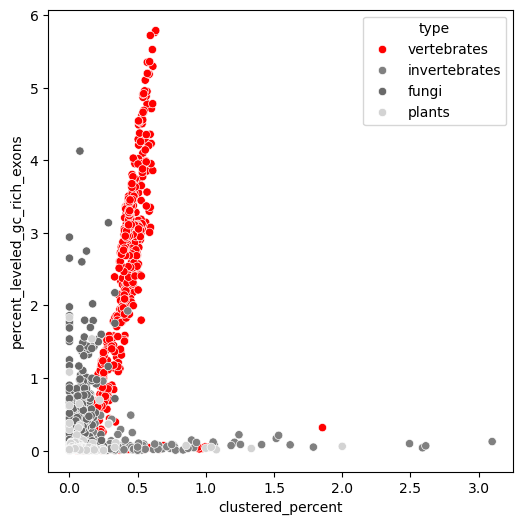

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

temp_df = all_merged.copy()
temp_df['type'] = temp_df.apply(lambda row: 'vertebrates' if row.type in ['mammalians', 'vertebrate_other'] else row.type, axis=1)

color_key = {'invertebrates':'gray',
             'vertebrates':'red',
             'plants':'lightgray',
             'fungi':'dimgray'
            }

ax1 = sns.scatterplot(temp_df,
                      x='clustered_percent', 
                      y = 'percent_leveled_gc_rich_exons', 
                      hue='type',
                      palette=color_key,
                      alpha=1,
                      ax=ax
                     )